#### TODO: add encoder-decoders comparison here; 
#### TODO: add supervised signal comparison here
#### TODO: add attention comparison here!
#### TODO: add paraphrasing baseline!
#### TODO (optional): add chapter of manual vs bt paraphrasing and lexical overlap
#### TODO: add boxplot for all language-pairs (all 900) for all languages for all layers in mBERT, move it to the "interlingua section"
#### TODO: correlate models interlinguality levels with their XNLI (or even full XTREME) performance from papers

In [2]:
# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
pwd

'/home/maksym/normal-transformers/examples'

In [5]:
import os
os.chdir('..')  # navigate to the root


In [6]:
from normal_transformers.util.util_data import pickle_load_from_file

In [7]:
from rpy2 import robjects
from rpy2.robjects import Formula, Environment
from rpy2.robjects.vectors import IntVector, FloatVector
from rpy2.robjects.lib import grid
from rpy2.robjects.packages import importr, data
from rpy2.rinterface_lib.embedded import RRuntimeError
import warnings

# The R 'print' function
rprint = robjects.globalenv.find("print")
stats = importr('stats')
grdevices = importr('grDevices')
base = importr('base')
datasets = importr('datasets')

grid.activate()

# plotting
import pandas as pd
import rpy2
import csv

from rpy2.robjects.lib import grdevices
from rpy2.robjects.vectors import IntVector, FloatVector
from IPython.display import Image, display

from rpy2.robjects import pandas2ri
pandas2ri.activate()

import rpy2.robjects as robjects
from rpy2.robjects.lib import grdevices
from rpy2.robjects.vectors import IntVector, FloatVector
from IPython.display import Image, display

import rpy2.robjects.packages as packages
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro

from rpy2.robjects.packages import STAP
with open('examples/theme_publication_tartunlp.R', 'r') as f:
    string = f.read()
pub_theme = STAP(string, "pub_theme")

/home/maksym/.conda/envs/norm/lib/python3.8/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


In [8]:
graphics = ro.packages.importr('graphics')
r_utils = ro.packages.importr('utils')
# r_utils.install_packages("ggthemes")
ggthemes = ro.packages.importr('ggthemes')

In [9]:
#r_utils.remove_packages('ggthemes')

In [10]:
model_names_mapping = {
    "xlm-roberta-large": "XLM-R_large",
    "xlm-roberta-base": "XLM-R_base",
    "bert-base-multilingual-cased": "mBERT_cased",
    "bert-base-multilingual-uncased": "mBERT_uncased",
    "distilbert-base-multilingual-cased": "distil_mBERT",
    "xlm-mlm-100-1280": "XLM-MLM_100"
}
    

In [11]:
savedir_base = f"assets/multilingual"

# Util

In [12]:
def load_sim_scores_csv(model_name_or_dir, exp_name, sim_name, sent_rep_type, lang_pairs):
    loaddir = f"experiments/{exp_name}/{model_name_or_dir}/similarity_scores/"
    sim_scores_dict = {}
    for lang_pair in lang_pairs:
        lp = lang_pair.replace("-", "_")
        fn = f"score-google_{sim_name}-{sent_rep_type}-{lp}.csv"
        
        try:
            with open(f'{loaddir}/{fn}') as csvfile:
                scores = [float(s) for s in list(csv.reader(csvfile))[0]]
                sim_scores_dict[lang_pair] = scores
        except:
            pass

    return sim_scores_dict

In [13]:
def load_sim_scores_into_df(model_name_or_dir, exp_name, sim_names, sent_rep_type, lang_pairs, lang_pairs_exclude=[]):
    # load metrics data
    sim_scores_all_metrics = {} 
    for sim_name in sim_names:
        scores = load_sim_scores_csv(
                                model_name_or_dir, 
                                exp_name, 
                                sim_name, 
                                sent_rep_type, 
                                lang_pairs)
        
        for lpair in lang_pairs_exclude:
            del scores[lpair]
            

        sim_scores_all_metrics[sim_name] = scores
        
    
    dict_of_sim_scors_dicts = sim_scores_all_metrics
    # craft padnas dataframe from it
    list_of_dfs = []
    for sim_name, sim_scores_dict in dict_of_sim_scors_dicts.items():
        tmp = {str(k).replace("-", "_"): v for k, v in sim_scores_dict.items()}
        sim_scores = tmp
        del tmp

        sim_scores_df = pd.DataFrame.from_dict(sim_scores)
        sim_scores_df["Layer"] = [i+1 for i in range(len(sim_scores_df))]
        
        sim_scores_df["Similarity"] = [str(sim_name).upper() for i in range(len(sim_scores_df))]
        sim_scores_df["Model"] = [model_names_mapping[model_name_or_dir] for i in range(len(sim_scores_df))]

        lang_pair_names = [v for v in sim_scores_df.columns.values if v != "Layer" and v != "Similarity" and v != "Model"]
        sim_scores_df = pd.melt(sim_scores_df, id_vars=["Layer", "Similarity", "Model"], value_vars=lang_pair_names,
                               var_name='lang_pair', value_name="Score")

        sim_scores_df = sim_scores_df.astype({"Layer": int})
        list_of_dfs.append(sim_scores_df)
    
    final_df = pd.concat(list_of_dfs, ignore_index=True) 
    
    return final_df

    

In [212]:
def ggplot2_plot_lines(df, 
                       title, 
                       target="Similarity", 
                       color="lang_pair",
                       nrow=1,
                       ncol=4,
                       scales="free_y"):
    gp = ggplot2.ggplot(sim_scores_df)
    pp = gp \
    + ggplot2.aes_string(x='Layer', y='Score') \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_line(ggplot2.aes_string(color = f"{color}")) \
    + ggplot2.facet_wrap(ro.Formula(f'. ~ {target}'), 
                         scales=f"{scales}", 
                         nrow=nrow,
                         ncol=ncol) \
    + ggplot2.scale_fill_manual(values=["#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF", "#3195FF"]) \
    + ggplot2.scale_x_continuous(labels = sim_scores_df["Layer"], breaks = sim_scores_df["Layer"]) \
    + ggplot2.theme(legend_position="bottom") \
    # + pub_theme.theme_Publication()
    

    return pp
    #pp.plot()

# 1. Sentence Representations

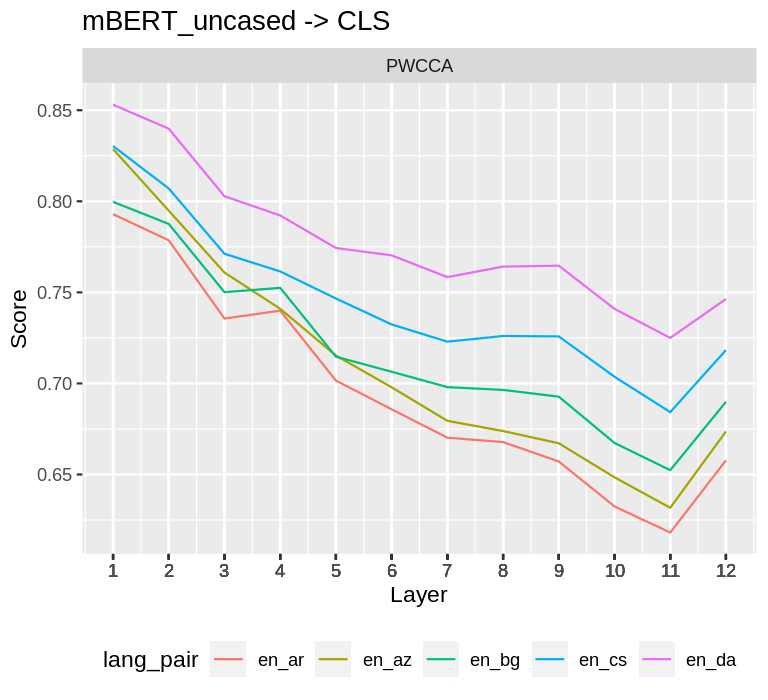

In [213]:
# GLOBALS
exp_name = "xnli_extension"
model_name_or_dir = "bert-base-multilingual-uncased"
sent_rep_type = "cls"
#sim_names = ["pwcca", "cka", "svcca_20"]
sim_names = ["pwcca"]
lang_pairs = ["en-ar", "en-az", "en-bg", "en-cs", "en-da", "en-en_shuf"]
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    exp_name=exp_name, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    lang_pairs_exclude=["en-en_shuf"])

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

* We reproduuced BertNotInterlingua pattern with PWCCA (the difference is due to improved tokenization)
* So BERT is not an interlingua?
* lets move further


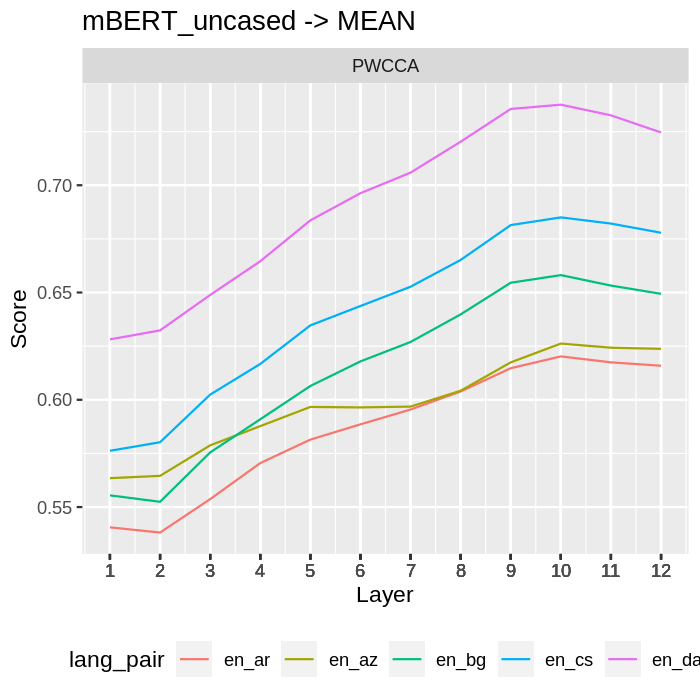

In [214]:
# GLOBALS
exp_name = "xnli_extension"
model_name_or_dir = "bert-base-multilingual-uncased"
sent_rep_type = "mean"
#sim_names = ["pwcca", "cka", "svcca_20"]
sim_names = ["pwcca"]
lang_pairs = ["en-ar", "en-az", "en-bg", "en-cs", "en-da", "en-en_shuf"]
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    exp_name=exp_name, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    lang_pairs_exclude=["en-en_shuf"])

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=700, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

In [215]:
# vualá! opposite trend!

# howver, we use PWCCA;
# it was there to surpress CCA, however SVCCA and especially CKA were shown to consistently outperform PWCCA
# SIngh uses PWCCA, Muller and Hu CKA,  Kudugunta SVCCA for a similar kind of analysis
# so lets see if this pattern really generalizes across metrics!

#  2. Similarity Measures

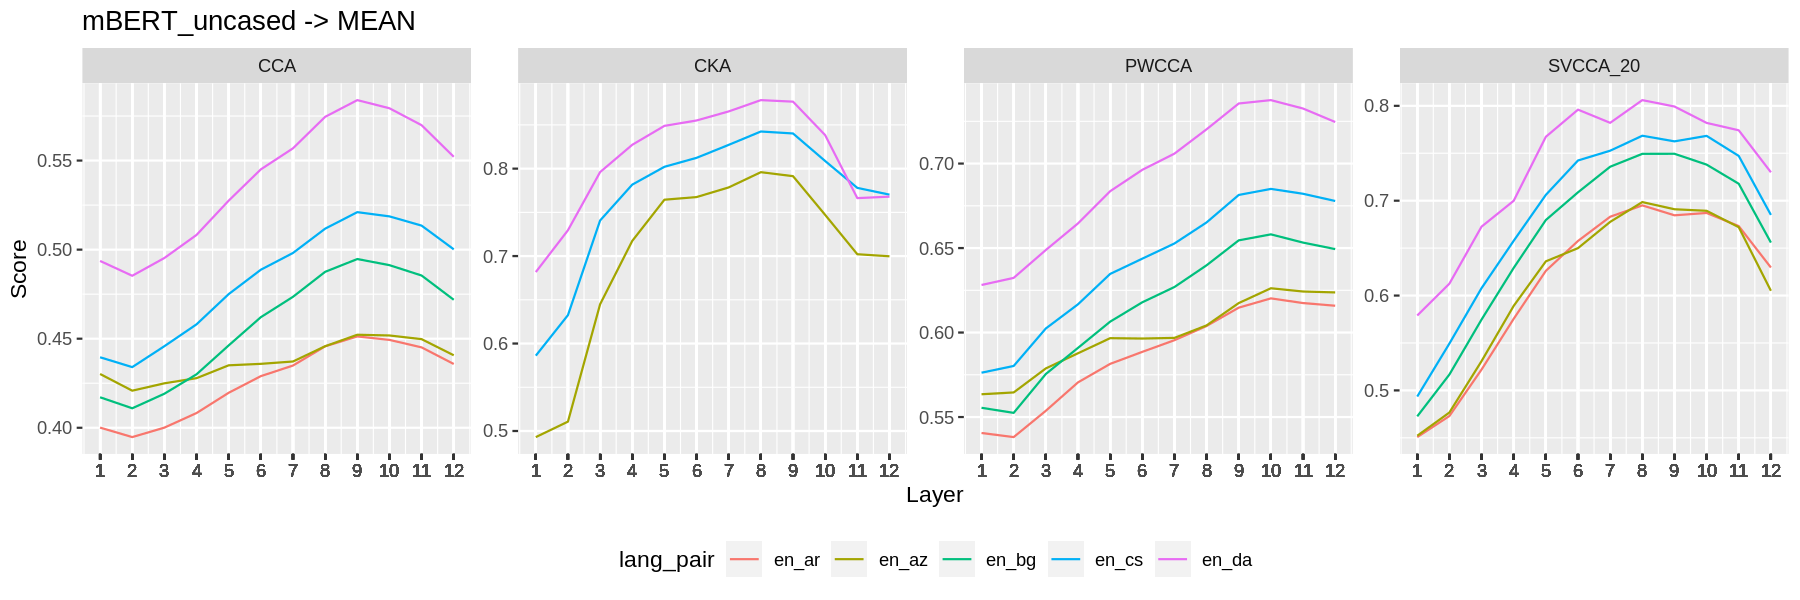

In [216]:
# GLOBALS
exp_name = "xnli_extension"
model_name_or_dir = "bert-base-multilingual-uncased"
sent_rep_type = "mean"
#sim_names = ["pwcca", "cka", "svcca_20"]
sim_names = ["pwcca", "cka", "svcca_20", "cca"]
lang_pairs = ["en-ar", "en-az", "en-bg", "en-cs", "en-da", "en-en_shuf"]
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    exp_name=exp_name, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    lang_pairs_exclude=["en-en_shuf"])

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1800, height=600, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

* We see that all the metrics revieal the pattern, however CKA and SVCCA (20 components) do it the best way!
* we use a different y-scale for each metric, becuase their values are not directly comparable between each other: a change of 0.1 for PWCCA might not be of the same significance as for CKA + absolue values are different
* that is why it is nice to compare them to the baseline!
* TODO: add paraphrasing baseline!

### Lets now add permutation baseline as a sanity check

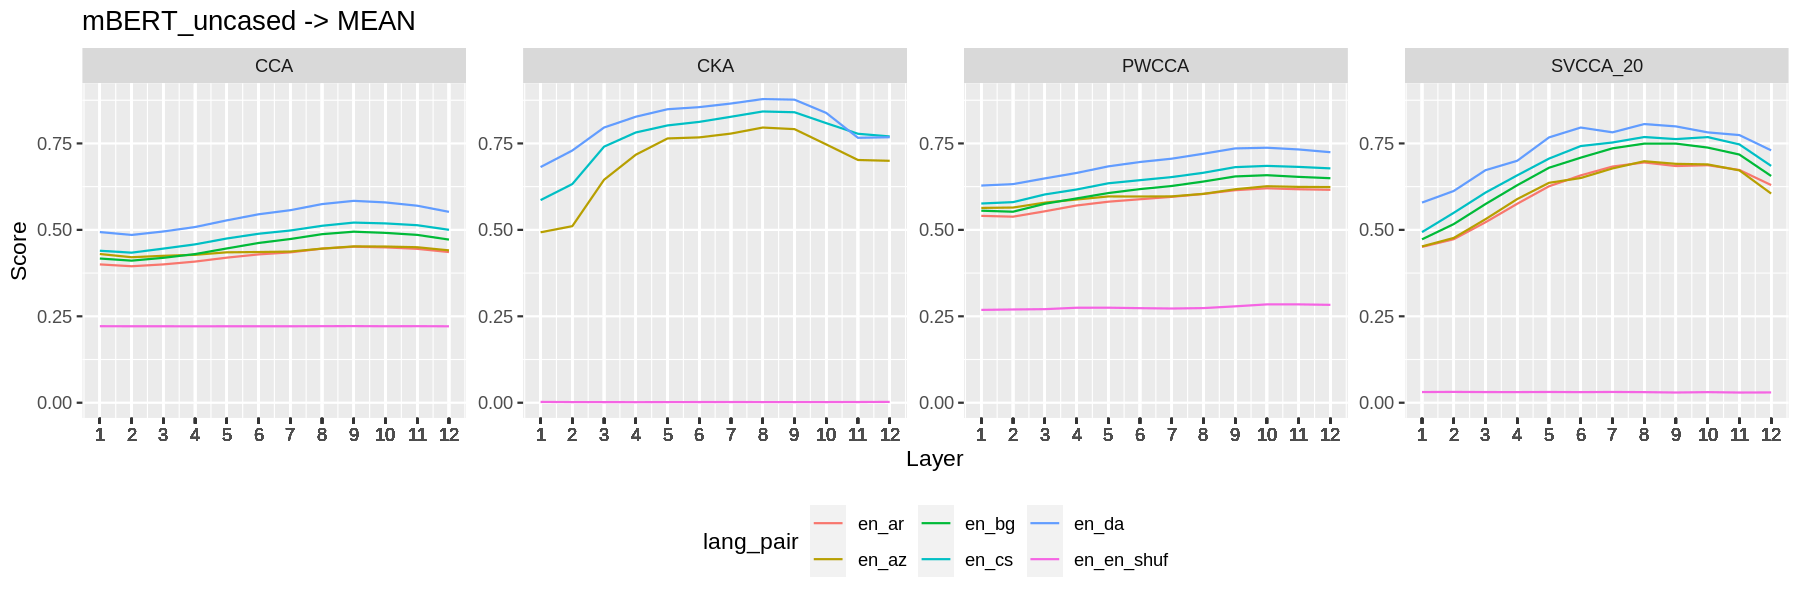

In [217]:
# GLOBALS
exp_name = "xnli_extension"
model_name_or_dir = "bert-base-multilingual-uncased"
sent_rep_type = "mean"
#sim_names = ["pwcca", "cka", "svcca_20"]
sim_names = ["pwcca", "cka", "svcca_20", "cca"]
lang_pairs = ["en-ar", "en-az", "en-bg", "en-cs", "en-da", "en-en_shuf"]
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    exp_name=exp_name, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    lang_pairs_exclude=[])

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1800, height=600, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot + ggplot2.ylim(0,0.88)
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

In [218]:
def ggplot2_plot_lines_enshuf(df, 
                       title, 
                       target="Similarity", 
                       color="lang_pair",
                       nrow=1,
                       ncol=4,
                       scales="free_y"):
    gp = ggplot2.ggplot(sim_scores_df)
    pp = gp \
    + ggplot2.aes_string(x='Layer', y='Score') \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_line(ggplot2.aes_string(color = f"{color}")) \
    + ggplot2.facet_wrap(ro.Formula(f'. ~ {target}'), 
                         scales=f"{scales}", 
                         nrow=nrow,
                         ncol=ncol) \
    + pub_theme.theme_Publication() \
    + ggplot2.scale_fill_manual(values=["#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF", "#3195FF"]) \
    + ggplot2.scale_x_continuous(labels = sim_scores_df["Layer"], breaks = sim_scores_df["Layer"])

    return pp

* we see that cca and pwcca have a bit harder time both discarding permutation baseline and show less stressed pattern
* since, as we discussed before, behavioural analysis strongly suggests the pattern, and considering above's we recommend to use CKA. 
* SVCCA is another good choice, but requires number components hyperparameter to tune; even though the default 20 works well

#### Single sentence instead of sentence-pair (probably move to appendix)

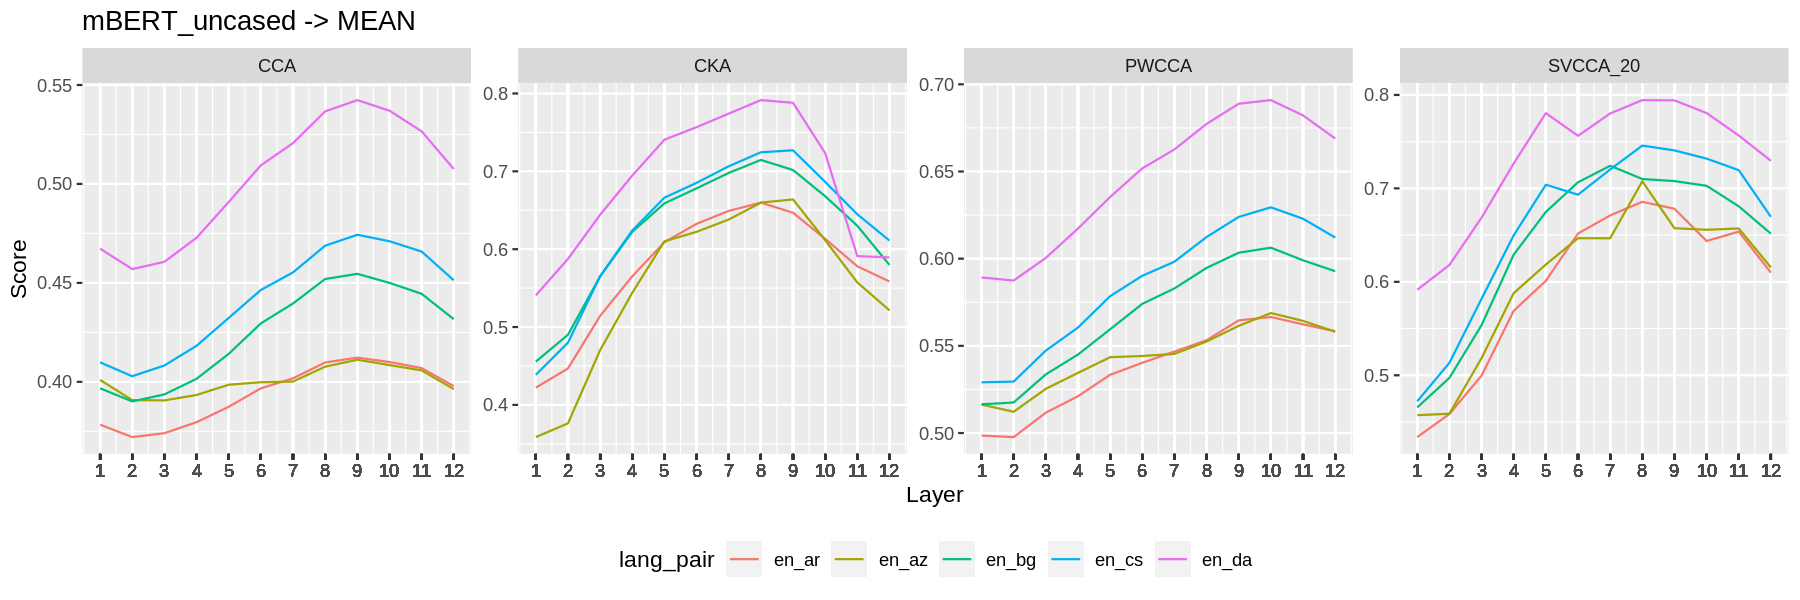

In [219]:
# GLOBALS
exp_name = "xnli_extension_onlyhyp"
model_name_or_dir = "bert-base-multilingual-uncased"
sent_rep_type = "mean"
#sim_names = ["pwcca", "cka", "svcca_20"]
sim_names = ["pwcca", "cka", "svcca_20", "cca"]
# sim_names = ["cka","pwcca"]
lang_pairs = ["en-ar", "en-az", "en-bg", "en-cs", "en-da", "en-en_shuf"]
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    exp_name=exp_name, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    lang_pairs_exclude=["en-en_shuf"])

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1800, height=600, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot 
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

* almost the same thing, just good to know and allows freely using single sentence data in the future

# 3. Models

In [220]:
def load_sim_scores_into_df_models(model_name_or_dir, exp_name, sim_names, sent_rep_type, lang_pairs, lang_pairs_exclude=[]):
    # load metrics data
    x_axes_name = "Network_depth"
    sim_scores_all_metrics = {} 
    for sim_name in sim_names:
        scores = load_sim_scores_csv(
                                model_name_or_dir, 
                                exp_name, 
                                sim_name, 
                                sent_rep_type, 
                                lang_pairs)
        
        for lpair in lang_pairs_exclude:
            del scores[lpair]
            

        sim_scores_all_metrics[sim_name] = scores
        
    
    dict_of_sim_scors_dicts = sim_scores_all_metrics
    # craft padnas dataframe from it
    list_of_dfs = []
    for sim_name, sim_scores_dict in dict_of_sim_scors_dicts.items():
        tmp = {str(k).replace("-", "_"): v for k, v in sim_scores_dict.items()}
        sim_scores = tmp
        del tmp

        sim_scores_df = pd.DataFrame.from_dict(sim_scores)
        sim_scores_df[f"{x_axes_name}"] = [(i+1) / len(sim_scores_df) for i in range(len(sim_scores_df))]
        
        sim_scores_df["Similarity"] = [str(sim_name).upper() for i in range(len(sim_scores_df))]
        sim_scores_df["Model"] = [model_names_mapping[model_name_or_dir] for i in range(len(sim_scores_df))]

        lang_pair_names = [v for v in sim_scores_df.columns.values if v != f"{x_axes_name}" and v != "Similarity" and v != "Model"]
        sim_scores_df = pd.melt(sim_scores_df, id_vars=[f"{x_axes_name}", "Similarity", "Model"], value_vars=lang_pair_names,
                               var_name='lang_pair', value_name="Score")

        sim_scores_df = sim_scores_df.astype({f"{x_axes_name}": float})
        list_of_dfs.append(sim_scores_df)
    
    final_df = pd.concat(list_of_dfs, ignore_index=True) 
    
    return final_df

    

In [227]:
def ggplot2_plot_lines_models(df, 
                       title, 
                       target="Similarity", 
                       color="lang_pair",
                       nrow=1,
                       ncol=4,
                       scales="free_y"):
    x_axes_name = "Network_depth"
    gp = ggplot2.ggplot(sim_scores_df)
    pp = gp \
    + ggplot2.aes_string(x=f'{x_axes_name}', y='Score') \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_line(ggplot2.aes_string(color = f"{color}")) \
    + ggplot2.facet_wrap(ro.Formula(f'. ~ {target}'), 
                         scales=f"{scales}", 
                         nrow=nrow,
                         ncol=ncol) \
    + ggplot2.scale_fill_manual(values=["#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF", "#3195FF"]) \
    + ggplot2.theme(legend_position="bottom") \

    # + pub_theme.theme_Publication() \
    

    return pp
    #pp.plot()

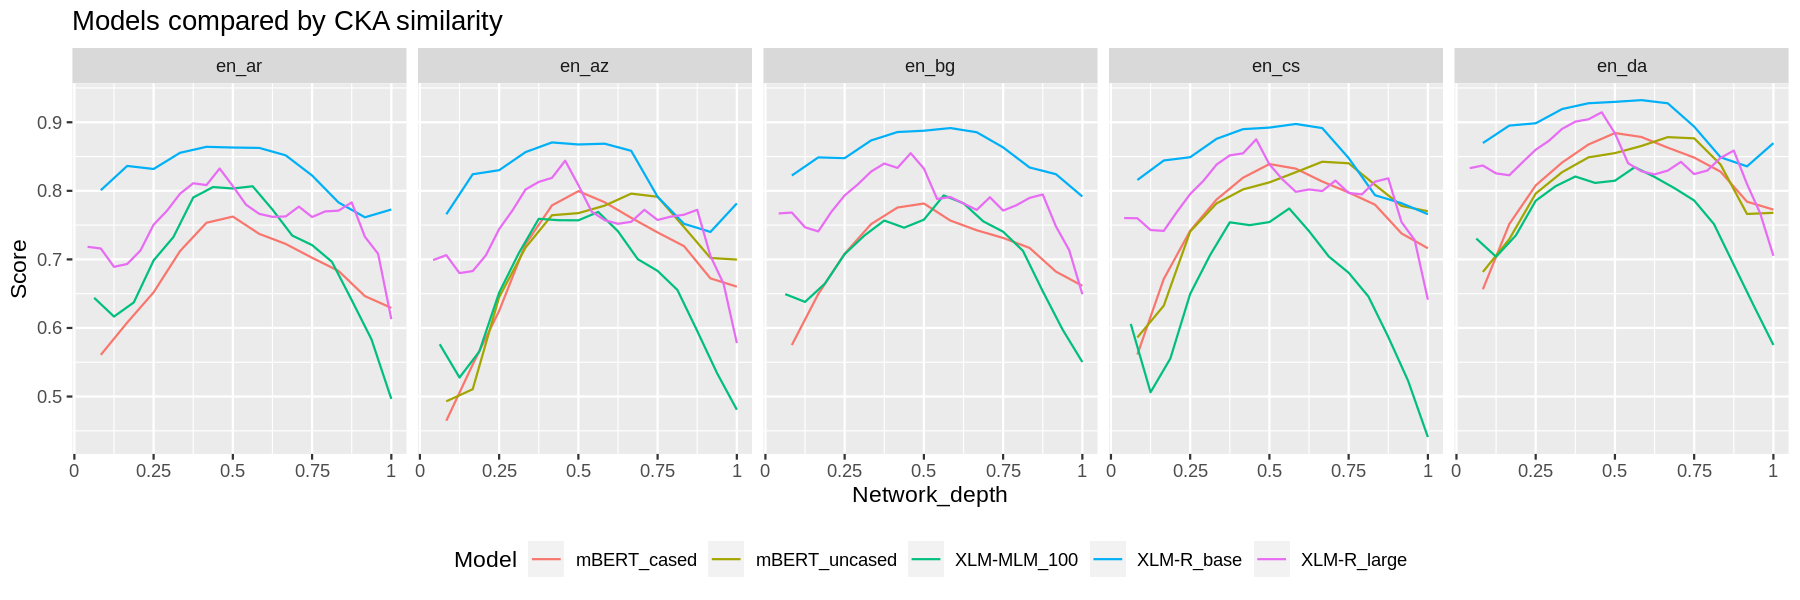

In [229]:

# GLOBALS


exp_name = "xnli_extension"
model_names_or_dirs = [
    "bert-base-multilingual-uncased",
    "bert-base-multilingual-cased",
    "xlm-roberta-base",
    "distilbert-base-multilingual-cased",
    "xlm-roberta-large",
    "xlm-mlm-100-1280",
]
sent_rep_type = "mean"
sim_names = ["cka"]
lang_pairs = ["en-da", "en-ar", "en-az", "en-cs", "en-bg"]

all_dfs = []
for model_name_or_dir in model_names_or_dirs:
    curr_sim_scores_df = load_sim_scores_into_df_models(
        model_name_or_dir=model_name_or_dir, 
        exp_name=exp_name, 
        sim_names=sim_names, 
        sent_rep_type=sent_rep_type, 
        lang_pairs=lang_pairs,
        lang_pairs_exclude=[])
    all_dfs.append(curr_sim_scores_df)
sim_scores_df = pd.concat(all_dfs, ignore_index=True) 

# plot metrics data
#with grdevices.render_to_bytesio(grdevices.png, width=2400, height=800, res=150) as img:
with grdevices.render_to_bytesio(grdevices.png, width=1800, height=600, res=150) as img:
    title = f"Models compared by CKA similarity"
    plot = ggplot2_plot_lines_models(sim_scores_df, 
                              title, 
                              target="lang_pair",
                              color="Model",
                             nrow=1,
                             ncol=5,
                             scales="fixed")
    plot = plot + ggplot2.scale_x_continuous(labels=ro.rl("""function(x) sprintf("%g", x)"""))
    plot.plot() 
display(Image(data=img.getvalue(), format='png', embed=True))

* All models resemble the pattern!
* TODO: in the paper add a table comparing different models (number of layers, total number of parameters, number of hidden units, data used to train, number of languages)
* 5 models is not bad, but why not use ALL huggingface multilingual models, including MT!!! 
* then maybe add ELMO and LASER from separate reposm should be quite easy, since they provide functions to extract representations for corpus
* if I have many models, it is better to do one big graph with additional graphs at appendix!

# 4. Interlingua

In [230]:
# r_utils.install_packages("cowplot")
cowplot = ro.packages.importr('cowplot')

Include xlm-r-base to the main body and add mbert-uncased to appendix, or side by side

In [231]:
import itertools
from normal_transformers.util import constants

In [279]:
def read_lang_matrix(all_langs, layer_id, exp_name, model_name_or_dir, sim_name, sent_rep_type, for_box_plot=False):
    
    if not for_box_plot:
        lang_matrix_df = pd.DataFrame(columns=['src','tgt','CKA'])

        all_pairs = list(itertools.combinations(all_langs, 2)) + [(l, l) for l in all_langs]

        loaddir = f"experiments/{exp_name}/{model_name_or_dir}/similarity_scores/"
        for pair in all_pairs:

            src_lang, tgt_lang = pair[0], pair[1]
#             if model_name_or_dir == "bert-base-multilingual-uncased" and (src_lang == "th" or tgt_lang == "th"):
#                 continue # bert-base-multilingual-uncased does not support Thai

            fn = f"score-google_{sim_name}-{sent_rep_type}-{src_lang}_{tgt_lang}.csv"

            with open(f'{loaddir}/{fn}') as csvfile:
                scores = [float(s) for s in list(csv.reader(csvfile))[0]]

                score = scores[layer_id]
                lang_matrix_df.loc[len(lang_matrix_df.index)] = [src_lang, tgt_lang, score]
                if src_lang != tgt_lang:
                    lang_matrix_df.loc[len(lang_matrix_df.index)] = [tgt_lang, src_lang, score]

        return lang_matrix_df
    else:
        lang_matrix_df = pd.DataFrame(columns=['lang_pair', 'CKA','Layer'])

        all_pairs = list(itertools.combinations(all_langs, 2))

        loaddir = f"experiments/{exp_name}/{model_name_or_dir}/similarity_scores/"
        for pair in all_pairs:

            src_lang, tgt_lang = pair[0], pair[1]
            if model_name_or_dir == "bert-base-multilingual-uncased" and (src_lang == "th" or tgt_lang == "th"):
                continue # bert-base-multilingual-uncased does not support Thai

            fn = f"score-google_{sim_name}-{sent_rep_type}-{src_lang}_{tgt_lang}.csv"

            with open(f'{loaddir}/{fn}') as csvfile:
                scores = [float(s) for s in list(csv.reader(csvfile))[0]]

                score = scores[layer_id]
                lang_matrix_df.loc[len(lang_matrix_df.index)] = [f"{src_lang}-{tgt_lang}", score, str(layer_id + 1)]

        return lang_matrix_df

We define interlingua as layer with highest CKA similarity value averaged between all pairs of languages 

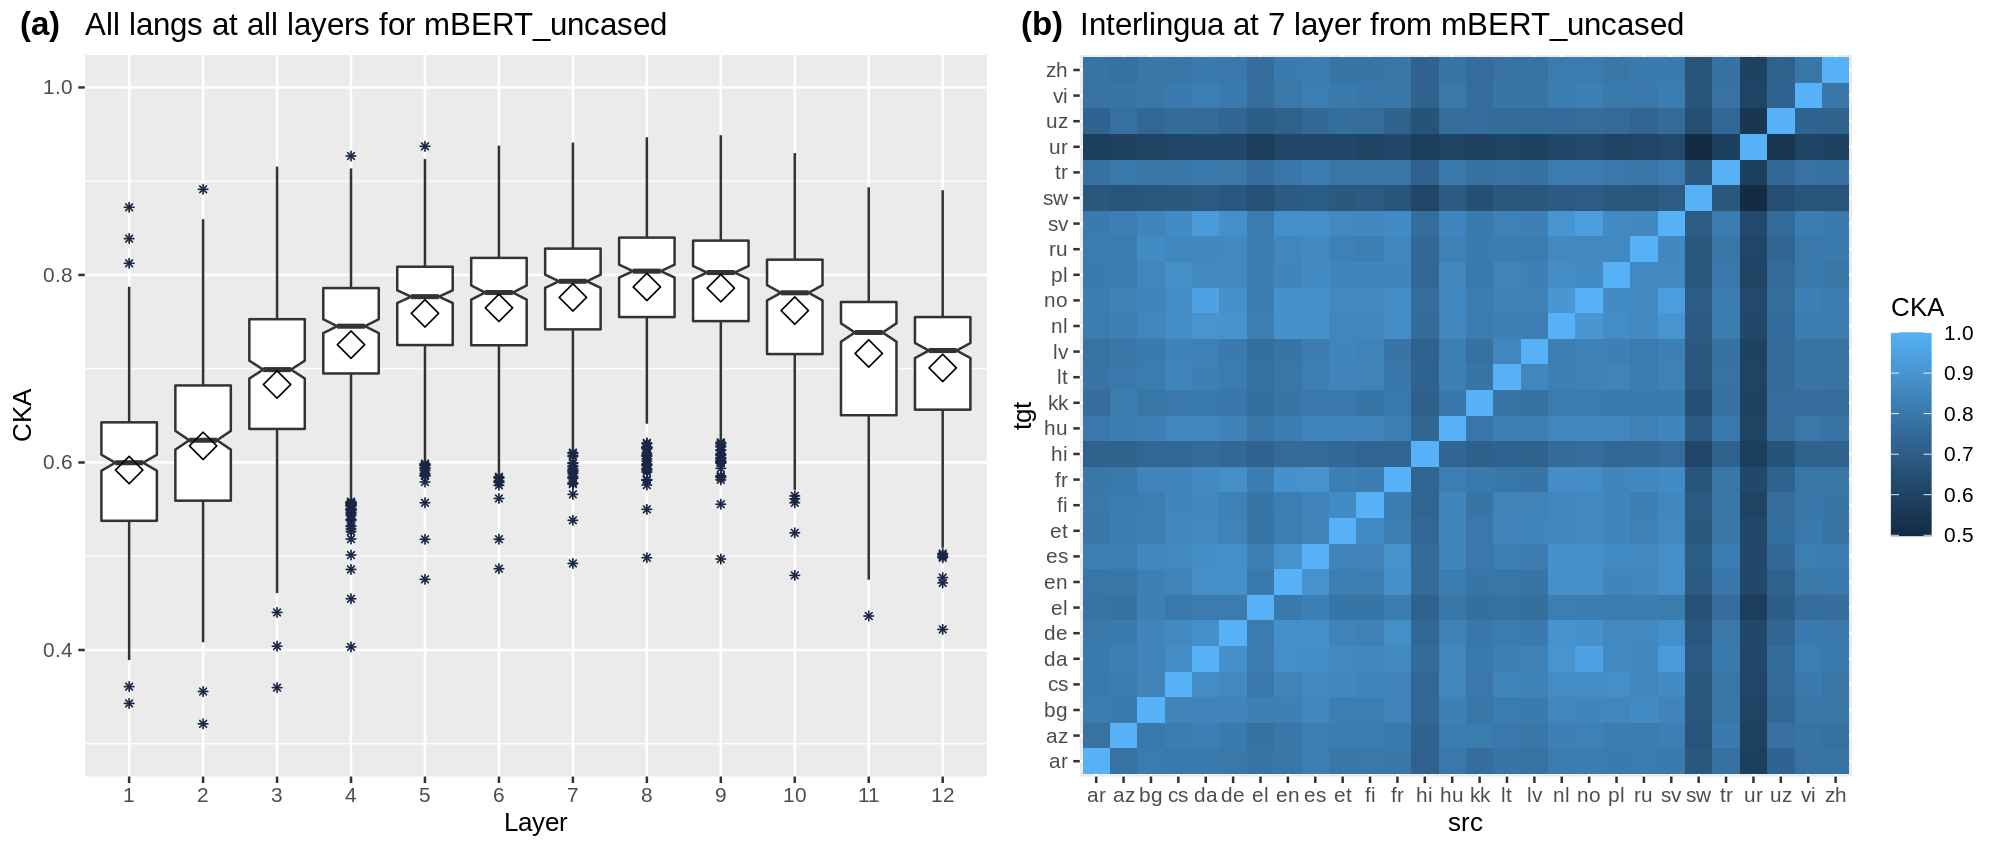

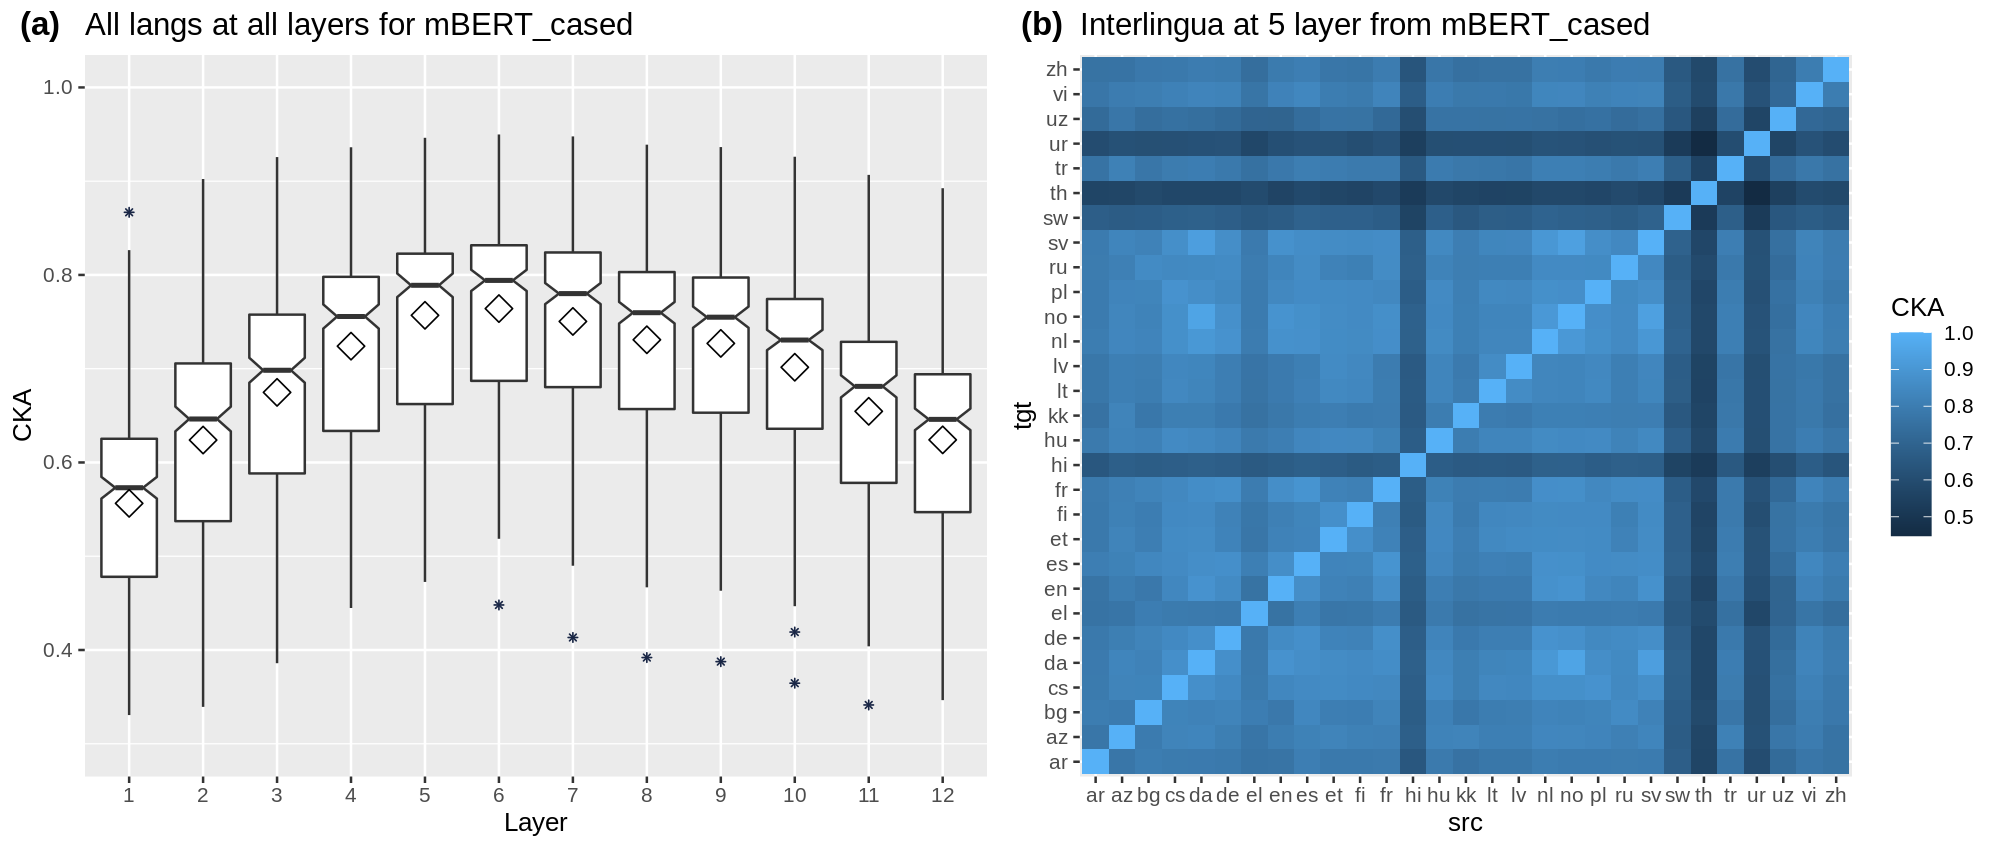

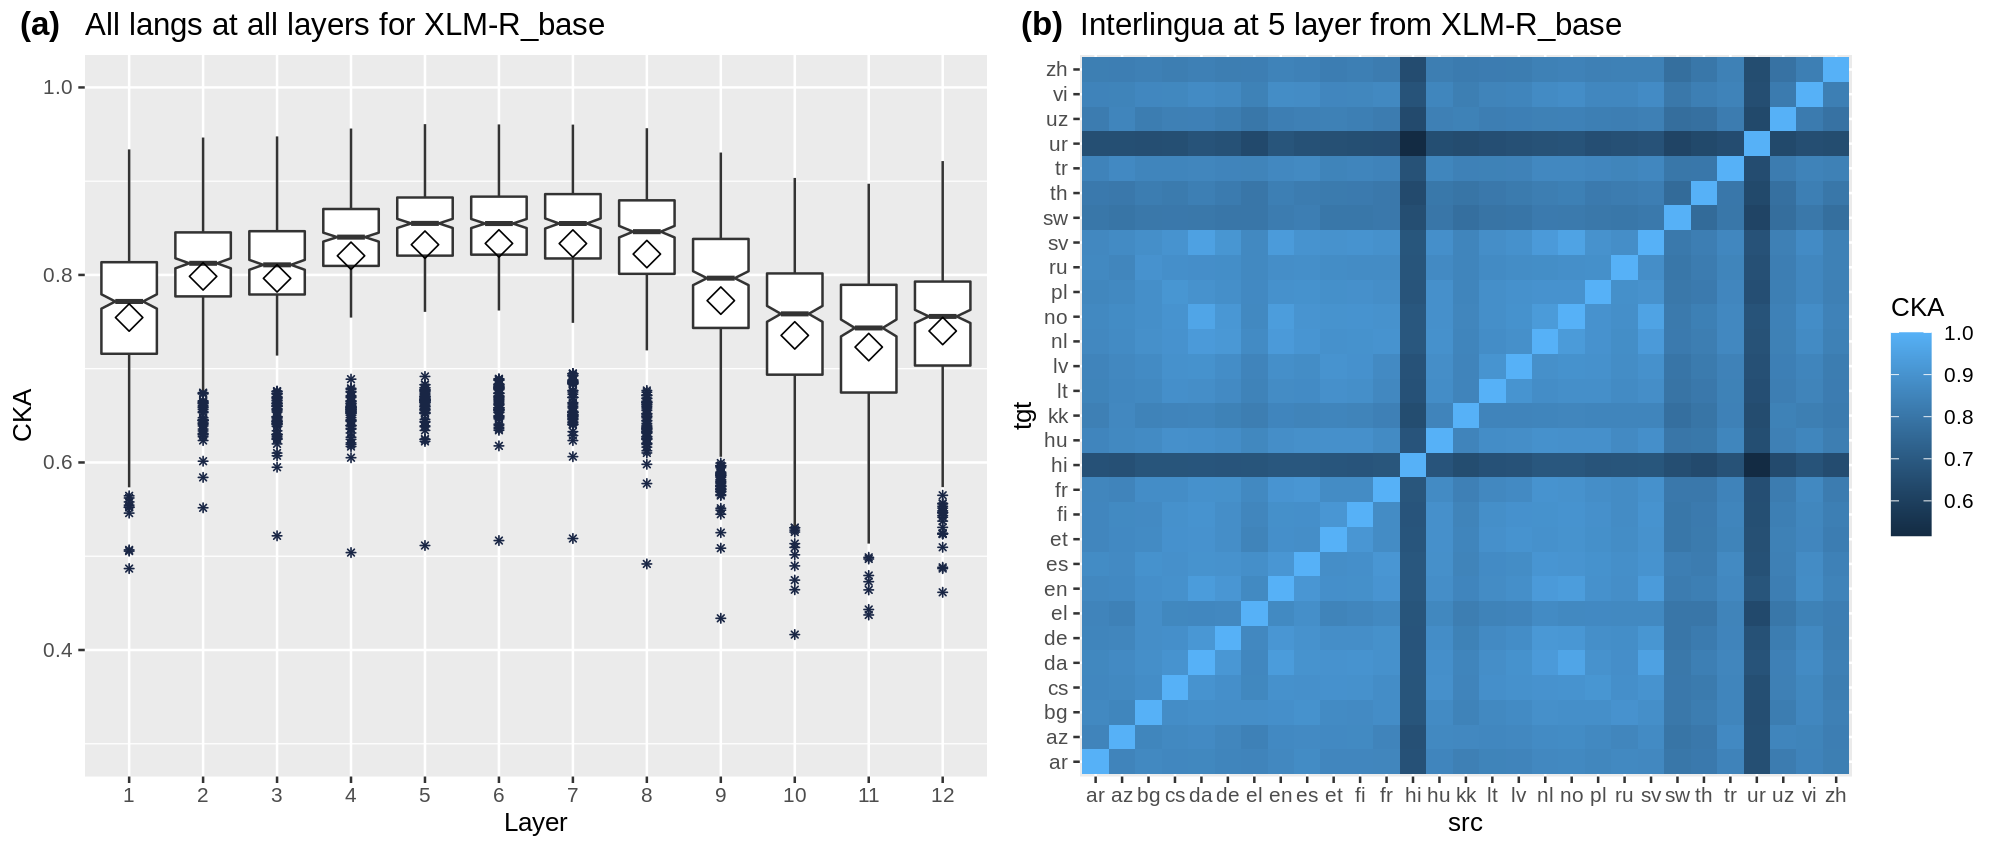

In [240]:
# model_name_or_dir = "bert-base-multilingual-uncased"
exp_name = "xnli_extension"
sent_rep_type = "mean"
sim_name = "cka"

for model_name_or_dir in ["bert-base-multilingual-uncased", "bert-base-multilingual-cased", "xlm-roberta-base"]:
    # read dfs
    avg_scores = []
    lang_matrix_dfs = []
    for i in range(12):
        layer_id = i
        lang_matrix_df = read_lang_matrix(all_langs=constants.xnli_extension_langs_all,
                                         layer_id=layer_id,
                                         exp_name=exp_name,
                                         model_name_or_dir=model_name_or_dir,
                                         sim_name=sim_name,
                                         sent_rep_type=sent_rep_type,
                                         for_box_plot=True
                                         )

        avg_scores.append(lang_matrix_df.sum()['CKA'] / len(lang_matrix_df))
        lang_matrix_dfs.append(lang_matrix_df)

    # concat, compute
    big_df = pd.concat(lang_matrix_dfs, ignore_index=True)
    interlingua_layer_id = avg_scores.index(max(avg_scores))

    # box plot
    title = f"All langs at all layers for {model_names_mapping[model_name_or_dir]}"
    gp = ggplot2.ggplot(big_df)
    boxplot = gp \
    + ggplot2.aes_string(x='Layer', y='CKA') \
    + ggplot2.ggtitle(title) \
    + ggplot2.scale_x_discrete(limits = ro.rl("""levels = c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12")""")) \
    + ggplot2.geom_boxplot(notch=True, outlier_colour="#192645", outlier_shape=8, outlier_size=1) \
    + ggplot2.stat_summary(fun_y=ro.rl("mean"), geom="point", shape=23, size=4) \
    + ggplot2.ylim(0.3, 1)
    # + pub_theme.theme_Publication()

    # heatmap
    lang_matrix_df = read_lang_matrix(all_langs=constants.xnli_extension_langs_all,
                                     layer_id=interlingua_layer_id,
                                     exp_name=exp_name,
                                     model_name_or_dir=model_name_or_dir,
                                     sim_name=sim_name,
                                     sent_rep_type=sent_rep_type
                                     )

    title = f"Interlingua at {interlingua_layer_id} layer from {model_names_mapping[model_name_or_dir]}"
    gp = ggplot2.ggplot(lang_matrix_df)
    heatmap = gp \
    + ggplot2.aes_string(x='src', y='tgt', fill="CKA") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile()

    # draw
    with grdevices.render_to_bytesio(grdevices.png, width=2000, height=850, res=170) as img:
        pp = cowplot.plot_grid(boxplot, heatmap, labels=['(a)', '(b)'])
        pp.plot() 
    display(Image(data=img.getvalue(), format='png', embed=True))

* mBERT uncased model does not support Thai, so we removed it!
* it looks like it is not enough to be low resource! you have to be both low-resouce and unrelated (SW and UR and HI are like that?), because if there is a close langauge, mBERT will share knowledge!!
* XLMR handels sw and th much better, hi and ur are still proble though

* Why hindi is so problematic? Does it require installing some additional packages for proper tokenization?

Graph above shows:
1) there is an interlingua in mBERT_uncased at 8th layer (highest average among all language pairs)
2) there is a number of language-pairs, that are outliers (orange dots) and do not fall nicely into the shared interlingual space (rectangualr boxes)

Consider:
* removing yellow outliers if thei distract?
* including grouping pictures by heatmaps and boxplots to compare bert and xlmr
* or keeping them like now, just together plz
* also consider making them small and fitting to 1/2 of the page
* note however, that y axes is not shared between heatmaps and boxplots, but could be

#### Just another way to arrange these things

In [254]:
# model_name_or_dir = "bert-base-multilingual-uncased"
exp_name = "xnli_extension"
sent_rep_type = "mean"
sim_name = "cka"


all_big_dfs = []
all_interlingua_layerids = []
for model_name_or_dir in ["bert-base-multilingual-uncased", "bert-base-multilingual-cased", "xlm-roberta-base"]:
    # read dfs
    avg_scores = []
    lang_matrix_dfs = []
    for i in range(12):
        layer_id = i
        lang_matrix_df = read_lang_matrix(all_langs=constants.xnli_extension_langs_all,
                                         layer_id=layer_id,
                                         exp_name=exp_name,
                                         model_name_or_dir=model_name_or_dir,
                                         sim_name=sim_name,
                                         sent_rep_type=sent_rep_type,
                                         for_box_plot=True
                                         )

        avg_scores.append(lang_matrix_df.sum()['CKA'] / len(lang_matrix_df))
        lang_matrix_dfs.append(lang_matrix_df)

    # concat, compute
    big_df = pd.concat(lang_matrix_dfs, ignore_index=True)
    big_df["Model"] = [model_names_mapping[model_name_or_dir] for i in range(len(big_df))]
    all_big_dfs.append(big_df)
    
    interlingua_layer_id = avg_scores.index(max(avg_scores))
    all_interlingua_layerids.append(interlingua_layer_id)
    
    
big_big_df = pd.concat(all_big_dfs, ignore_index=True)

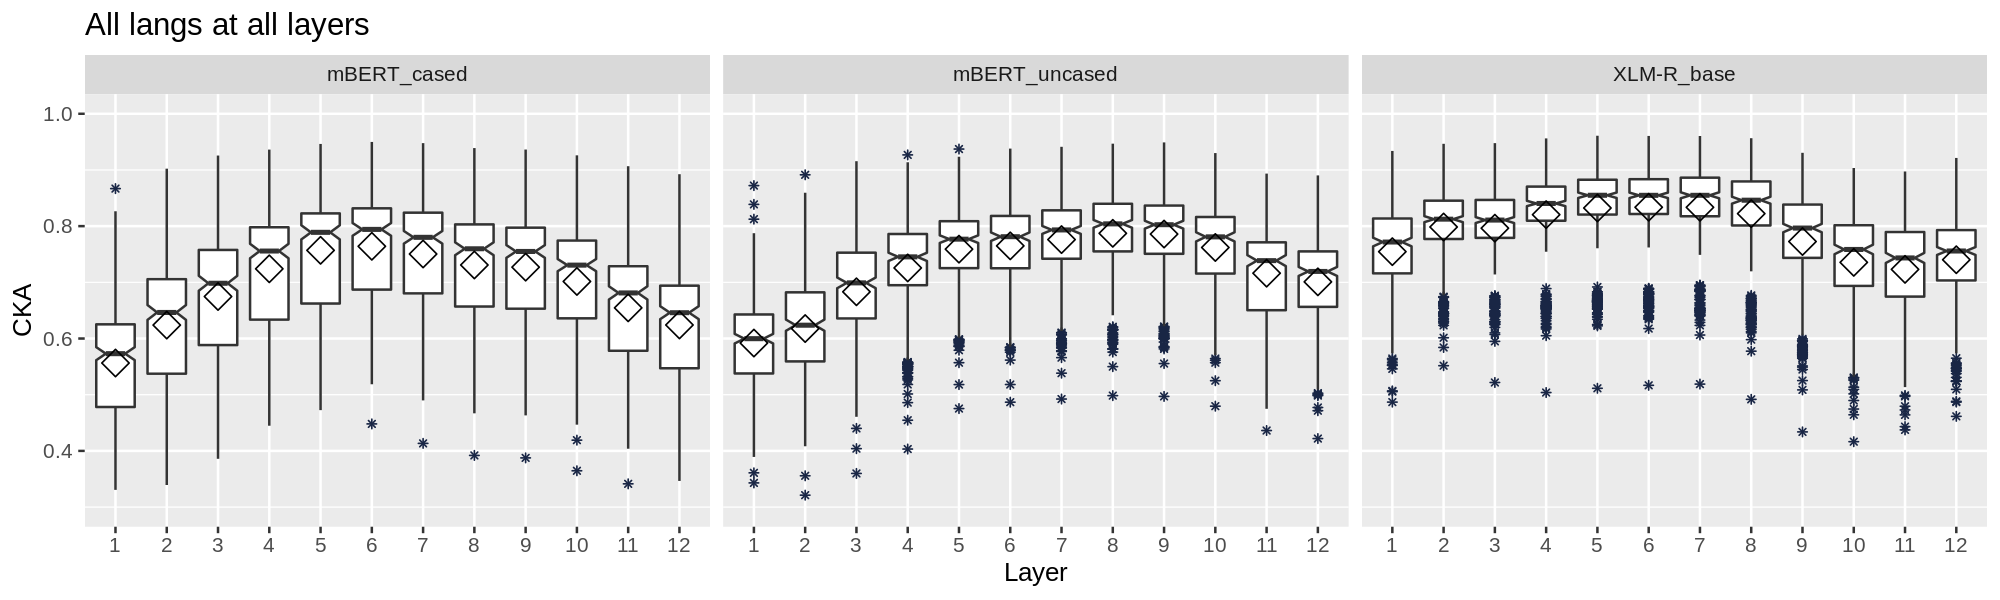

In [285]:
# box plot
title = f"All langs at all layers"
gp = ggplot2.ggplot(big_big_df)
boxplot = gp \
+ ggplot2.aes_string(x='Layer', y='CKA') \
+ ggplot2.facet_grid(ro.Formula(f'. ~ Model')) \
+ ggplot2.ggtitle(title) \
+ ggplot2.scale_x_discrete(limits = ro.rl("""levels = c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12")""")) \
+ ggplot2.geom_boxplot(notch=True, outlier_colour="#192645", outlier_shape=8, outlier_size=1) \
+ ggplot2.stat_summary(fun_y=ro.rl("mean"), geom="point", shape=23, size=4) \
+ ggplot2.ylim(0.3, 1)

with grdevices.render_to_bytesio(grdevices.png, width=2000, height=600, res=170) as img:
    boxplot.plot() 
display(Image(data=img.getvalue(), format='png', embed=True))

Nah, I already compared models, this one is not needed I think

In [280]:
dfs = []
for i, model_name_or_dir in enumerate(["bert-base-multilingual-uncased", "bert-base-multilingual-cased", "xlm-roberta-base"]):
    interlingua_layer_id = all_interlingua_layerids[i]
    
    df = read_lang_matrix(all_langs=constants.xnli_extension_langs_all,
                                 layer_id=interlingua_layer_id,
                                 exp_name=exp_name,
                                 model_name_or_dir=model_name_or_dir,
                                 sim_name=sim_name,
                                 sent_rep_type=sent_rep_type
                                 )
    
    df['Model'] = [model_names_mapping[model_name_or_dir] for i in range(len(df))]
    dfs.append(df)
big_df = pd.concat(dfs, ignore_index=True)

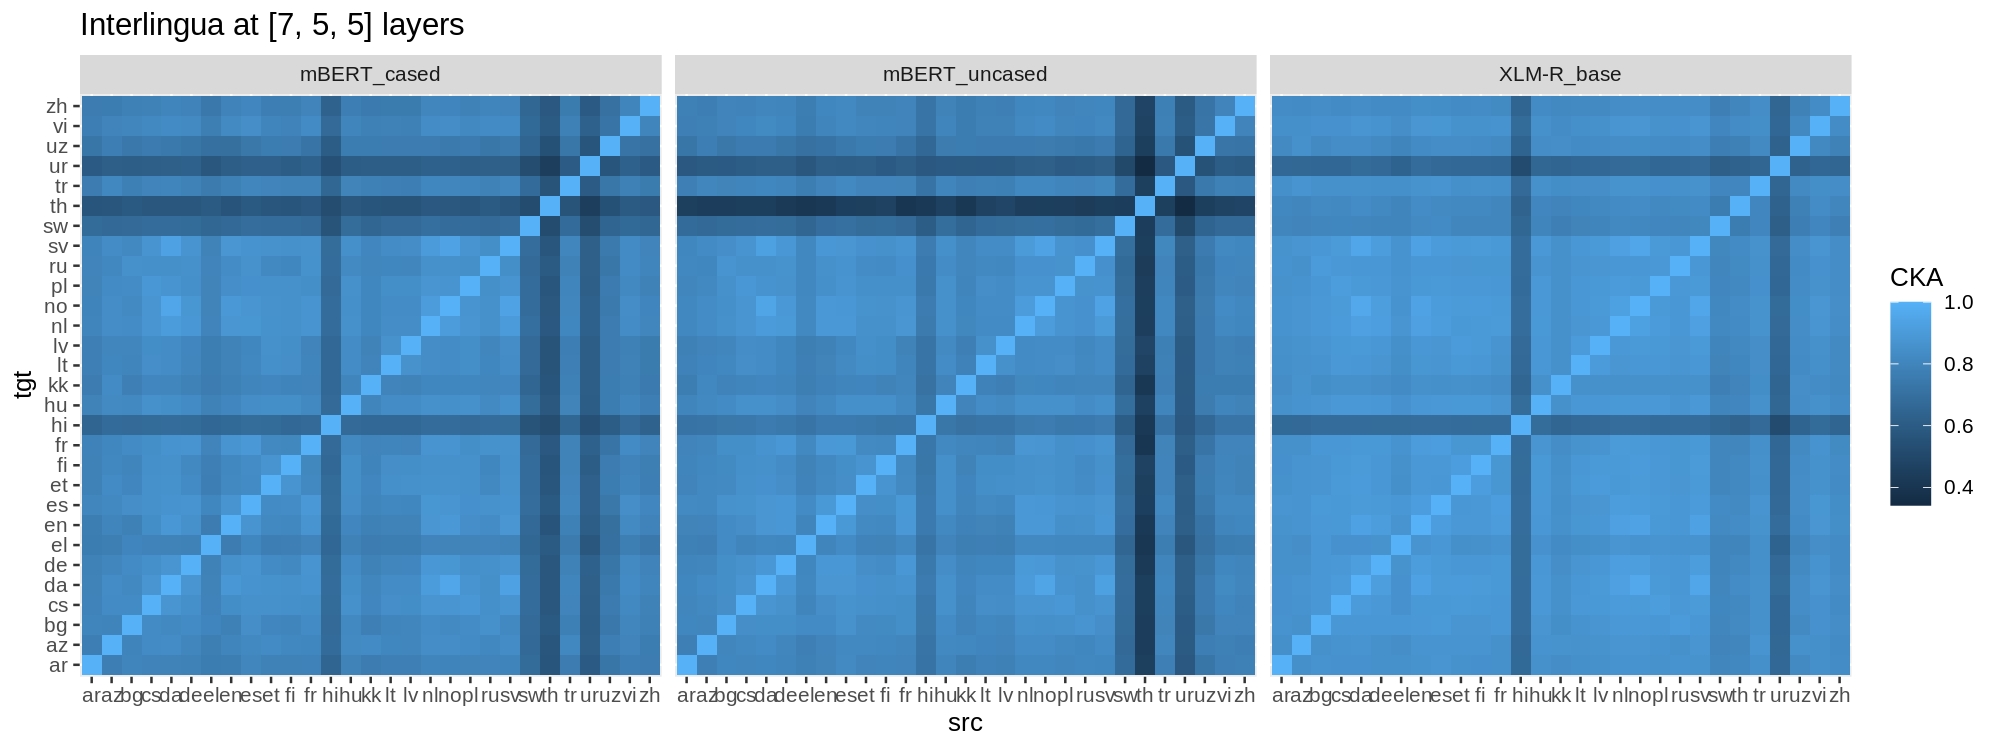

In [286]:
# heatmap
title = f"Interlingua at {all_interlingua_layerids} layers"
gp = ggplot2.ggplot(big_df)
heatmap = gp \
+ ggplot2.aes_string(x='src', y='tgt', fill="CKA") \
+ ggplot2.facet_wrap(ro.Formula(f'. ~ Model')) \
+ ggplot2.ggtitle(title) \
+ ggplot2.geom_tile()

# draw
with grdevices.render_to_bytesio(grdevices.png, width=2000, height=750, res=170) as img:
    pp = heatmap
    pp.plot() 
display(Image(data=img.getvalue(), format='png', embed=True))